## Load the data

In [1]:
# load packages
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Load data
with open('data/msd_full.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

doscaling = 1
if (doscaling == 1):
    xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
    # standardize feature values
    X_train = xscaler.transform(msd_data['X_train'])
    X_test = xscaler.transform(msd_data['X_test'])
else:
    X_train = msd_data['X_train']
    X_test = msd_data['X_test']

Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test'].astype('float32')
X_test = X_test.astype('float32')
X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')

y_mean = Y_train.mean()
Y_train_keep = Y_train.copy()
Y_test_keep = Y_test.copy()
Y_train = Y_train - y_mean
Y_test = Y_test - y_mean


# validation is the last 10% of training, subtraining is the first 90% of training
nvalid = int(X_train.shape[0] * 0.1)
nsubtrain = X_train.shape[0] - nvalid

X_subtrain = X_train[0:nsubtrain, :].astype('float32')
X_valid = X_train[nsubtrain:, :].astype('float32')
Y_subtrain = Y_train[0:nsubtrain].astype('float32')
Y_valid = Y_train[nsubtrain:].astype('float32')

Y_subtrain_keep = Y_train_keep[0:nsubtrain].astype('float32')
Y_valid_keep = Y_train_keep[nsubtrain:].astype('float32')

print("nvalid = ", nvalid)
print("nsubtrain = ", nsubtrain)
print("X_train shape = ", X_train.shape)
print("X_subtrain shape = ", X_subtrain.shape)
print("X_valid shape = ", X_valid.shape)
print("X_test shape = ", X_test.shape)
print("Y_train shape = ", Y_train.shape)
print("Y_subtrain shape = ", Y_subtrain.shape)
print("Y_valid shape = ", Y_valid.shape)
print("Y_test shape = ", Y_test.shape)

nvalid =  46371
nsubtrain =  417344
X_train shape =  (463715, 90)
X_subtrain shape =  (417344, 90)
X_valid shape =  (46371, 90)
X_test shape =  (51630, 90)
Y_train shape =  (463715,)
Y_subtrain shape =  (417344,)
Y_valid shape =  (46371,)
Y_test shape =  (51630,)


## Q1

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


reg = LinearRegression().fit(X_train, Y_train)
Y_pred = reg.predict(X_test)
rmse = mean_squared_error(Y_test, Y_pred, squared=False)

print("rmse:", rmse)
print("first five coefficients:", reg.coef_[:5])
print("intercept:", reg.intercept_)

rmse: 9.510161
first five coefficients: [ 5.3097544  -2.8808796  -1.532341    0.05737364 -0.33952868]
intercept: 0.00010863347


## Q2 MLP with Four Hidden Layers
建構一個有四層Hidden Layer的MLP。此模型由輸入層開始，90個Input Features通過線性層轉換為H個Hidden Nodes，並通過ReLu Activation Function，此為第一層Hidden Layer。
接著通過下一個線性層與ReLu Activation Function，此為第二層。接著下一個線性層與ReLu Activation Function，此為第三層。
然後下一個線性層與ReLu Activation Function，此為第四層。最後通過一個線性層輸出。
所有Hidden Layer的寬度都為H。

令H= 45, 使用Stochastic Gradient Descent更新參數，設Learning Rate = 0.00001，無Weight Decay與Momentum。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。

In [3]:
import torch
from torch.utils import data

# 先做出Dataset再擺入dataloader
# Characterizes a dataset for PyTorch
class Dataset(data.Dataset):
    def __init__(self, Xnp, Ynp):
    # Initialization, passing Xnp and Ynp
        self.nobs = Xnp.shape[0]
        self.Xnp = Xnp
        self.Ynp = Ynp
    def __len__(self):
    # Denotes the total number of samples
        return self.nobs

    def __getitem__(self, index):
    # Generates one sample of data
        X = self.Xnp[index]
        y = self.Ynp[index]
        return X, y

trainset = Dataset(X_train, Y_train)
subtrainset = Dataset(X_subtrain, Y_subtrain)
validset = Dataset(X_valid, Y_valid)
testset = Dataset(X_test, Y_test)

Create Dataloader

In [4]:
trainloader = data.DataLoader(trainset, batch_size=1000, shuffle=True, num_workers=0)
subtrainloader = data.DataLoader(subtrainset, batch_size=1000, shuffle=True, num_workers=0)
validloader = data.DataLoader(validset, batch_size=1000, shuffle=True, num_workers=0)
testloader = data.DataLoader(testset, batch_size=1000, shuffle=True, num_workers=0)

In [5]:
# check
X_batch, y_batch = next(iter(trainloader))
print("inputs size:", X_batch.size())
print("targets size:", y_batch.size())

inputs size: torch.Size([1000, 90])
targets size: torch.Size([1000])


In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Model architecture

In [7]:
class MLP(torch.nn.Module):
    def __init__(self, D_in, D_out, H):
        super(MLP, self).__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Linear(D_in, H),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            torch.nn.Linear(H, D_out))

    def forward(self, input):
        return self.main(input)

Train

In [8]:
def train(model, device, epochs, optimizer, loss_function, train_loader, valid_loader, prints=1):
    # Early stopping
    stop_train = 0
    
    min_valid_loss = np.inf
    step_count = 0
    best_step_count = 0
    train_loss = 0
    train_loss_list = []
    valid_loss_list = []
    batches = []

    for epoch in range(1, epochs+1):
#         print('running epoch: {}'.format(epoch))
        model.train()

        for i, data in enumerate(train_loader, 1):
            step_count += 1
            inputs = data[0].to(device)
            labels = data[1].to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward and backward propagation
            outputs = model(inputs.view(inputs.shape[0], -1))
            loss = loss_function(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            if step_count % 100 == 0:
                valid_loss = validation(model, device, valid_loader, loss_function)
                batches.append(step_count)
                valid_loss_list.append(valid_loss)
                train_loss_list.append((train_loss/step_count)**0.5)
                if valid_loss < min_valid_loss:
                    min_valid_loss = valid_loss
                    best_step_count = step_count
                if step_count == best_step_count + 5000:
                    stop_train = 1
                if step_count % 1000 == 0 and prints == 1:
                    print('Batch: %d Training Loss: %.4f Validation Loss: %.4f' % (step_count, (train_loss/step_count)**0.5, valid_loss))
                    print('Current best validation RMSE: %.4f @ %d' % (min_valid_loss, best_step_count))
                
        if stop_train == 1:
            break
    if prints == 1:
        print('==================== Training Finished ====================')

    return model, train_loss_list, valid_loss_list, batches

Validation

In [9]:
def validation(model, device, valid_loader, loss_function):
    # Settings
    model.eval()
    loss_total = 0

    # Test validation data
    with torch.no_grad():
        for data in valid_loader:
            inputs = data[0].to(device)
            labels = data[1].to(device)

            outputs = model(inputs.view(inputs.shape[0], -1))
            loss = loss_function(outputs, labels.unsqueeze(1))
            loss_total += loss.item()

    return (loss_total / len(valid_loader))**0.5

Test

In [10]:
def test(model, device, test_loader, loss_function):
    # Settings
    model.eval()
    loss_total = 0

    # Test validation data
    with torch.no_grad():
        for data in test_loader:
            inputs = data[0].to(device)
            labels = data[1].to(device)

            outputs = model(inputs.view(inputs.shape[0], -1))
            loss = loss_function(outputs, labels.unsqueeze(1))
            loss_total += loss.item()
    
    test_loss = (loss_total / len(test_loader))**0.5
    
    print('Test Loss: %.4f' % test_loss)
    
    return test_loss

Setting up and run

In [47]:
D_in = trainset.Xnp.shape[1]  # 90
D_out = 1
H = 45
epochs = 100

model = MLP(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
loss_function = torch.nn.MSELoss()

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader)
# Test
test(model[0], device, testloader, loss_function)

Batch: 1000 Training Loss: 10.9379 Validation Loss: 10.9376
Current best validation RMSE: 10.9108 @ 600
Batch: 2000 Training Loss: 10.9412 Validation Loss: 10.9195
Current best validation RMSE: 10.9108 @ 600
Batch: 3000 Training Loss: 10.9402 Validation Loss: 10.9220
Current best validation RMSE: 10.9057 @ 2600
Batch: 4000 Training Loss: 10.9423 Validation Loss: 10.9199
Current best validation RMSE: 10.9057 @ 2600
Batch: 5000 Training Loss: 10.9420 Validation Loss: 10.9180
Current best validation RMSE: 10.9057 @ 2600
Batch: 6000 Training Loss: 10.9429 Validation Loss: 10.9154
Current best validation RMSE: 10.9057 @ 2600
Batch: 7000 Training Loss: 10.9417 Validation Loss: 10.9284
Current best validation RMSE: 10.9050 @ 6200
Batch: 8000 Training Loss: 10.9423 Validation Loss: 10.9200
Current best validation RMSE: 10.9050 @ 6200
Batch: 9000 Training Loss: 10.9424 Validation Loss: 10.9171
Current best validation RMSE: 10.9050 @ 6200
Batch: 10000 Training Loss: 10.9423 Validation Loss: 10.9

10.851792583570978

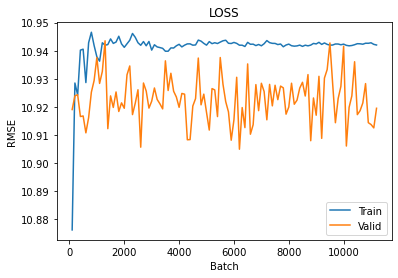

In [52]:
plt.plot(model[3], model[1])
plt.plot(model[3], model[2])

plt.title('LOSS')
plt.xlabel('Batch')
plt.ylabel('RMSE')
plt.legend(['Train', 'Valid'])
plt.show()

### Q2 Conclusion
觀察圖形可以發現在Batch較小時Train loss較低，而當Batch到達到2000時，Train loss達到穩定狀態。
另外，也可看出Valid loss在一定範圍內震盪。

## Q3
重複上題步驟，使用H = 90與180。無須畫訓練過程的RMSE。列出這兩個Test RMSE。討論H = 45, 90, 180的Test RMSE。

H: 90

In [13]:
H = 90

model = MLP(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
loss_function = torch.nn.MSELoss()

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader, 0)
# Test
test(model[0], device, testloader, loss_function)

Test Loss: 10.8531


10.853060507674094

H: 180

In [14]:
H = 180

model = MLP(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
loss_function = torch.nn.MSELoss()

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader, 0)
# Test
test(model[0], device, testloader, loss_function)

Test Loss: 10.8501


10.850131146903733

### Q3 Conclusion
RMSE從大排到小依據是 90 > 45 > 180，因此可知不一定hidden layer越多的話，表現會越好。

## Q4
使用Q2的模型設定，考慮 H = 45, 90, 180與Weight Decay = 0.1, 0.2, 0.4的所有組合。模型估計後做表整理Test RMSE。討論H的選擇應為多少較合理?

H = 45, weight decay = 0.1

In [15]:
H = 45

model = MLP(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.1)
loss_function = torch.nn.MSELoss()

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader, 0)
# Test
test_45_1 = test(model[0], device, testloader, loss_function)

Test Loss: 10.8610


H = 45, weight decay = 0.2

In [16]:
H = 45

model = MLP(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.2)
loss_function = torch.nn.MSELoss()

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader, 0)
# Test
test_45_2 = test(model[0], device, testloader, loss_function)

Test Loss: 10.8557


H = 45, weight decay = 0.4

In [17]:
H = 45

model = MLP(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.4)
loss_function = torch.nn.MSELoss()

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader, 0)
# Test
test_45_4 = test(model[0], device, testloader, loss_function)

Test Loss: 10.8500


H = 90, weight decay = 0.1

In [18]:
H = 90

model = MLP(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.1)
loss_function = torch.nn.MSELoss()

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader, 0)
# Test
test_90_1 = test(model[0], device, testloader, loss_function)

Test Loss: 10.8522


H = 90, weight decay = 0.2

In [19]:
H = 90

model = MLP(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.2)
loss_function = torch.nn.MSELoss()

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader, 0)
# Test
test_90_2 = test(model[0], device, testloader, loss_function)

Test Loss: 10.8472


H = 90, weight decay = 0.4

In [20]:
H = 90

model = MLP(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.4)
loss_function = torch.nn.MSELoss()

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader, 0)
# Test
test_90_4 = test(model[0], device, testloader, loss_function)

Test Loss: 10.8546


H = 180, weight decay = 0.1

In [21]:
H = 180

model = MLP(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.1)
loss_function = torch.nn.MSELoss()

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader, 0)
# Test
test_180_1 = test(model[0], device, testloader, loss_function)

Test Loss: 10.8543


H = 180, weight decay = 0.2

In [22]:
H = 180

model = MLP(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.2)
loss_function = torch.nn.MSELoss()

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader, 0)
# Test
test_180_2 = test(model[0], device, testloader, loss_function)

Test Loss: 10.8557


H = 180, weight decay = 0.4

In [23]:
H = 180

model = MLP(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.4)
loss_function = torch.nn.MSELoss()

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader, 0)
# Test
test_180_4 = test(model[0], device, testloader, loss_function)

Test Loss: 10.8556


In [24]:
import pandas as pd

pd.DataFrame({
    '45': [test_45_1, test_45_2, test_45_4],
    '90': [test_90_1, test_90_2, test_90_4],
    '180': [test_180_1, test_180_2, test_180_4]},
    index=['0.1', '0.2', '0.4'])

,45,90,180
0.1,10.861015,10.852201,10.854303
0.2,10.855688,10.847180,10.855722
0.4,10.849968,10.854632,10.855584


### Q4 Conclusion
weight decay = 0.1時: 45 > 180 > 90

weight decay = 0.2時: 180 > 45 > 90

weight decay = 0.4時: 180 > 90 > 45

在這當中最低的是weight decay = 0.2, H = 90。且H = 90在兩個weight decay表現下最好，因此我認為假設在有weight decay的情形下， H應該選擇90。

## Q5 MLP with Dropout
建構一個有Dropout的四層Hidden Layer的MLP。此模型由輸入層開始，第一層由90個Input Features通過線性層轉換為H個Hidden Nodes，通過ReLu Activation Function，之後對Hidden Unit Dropout，機率為0.5。後面各Hidden Lyaer均在ReLu後有Dropout，機率皆為0.5。最後通過一個線性層輸出。所有Hidden Layer的寬度都為H。

令H= 90, 使用Adaptive Moment Estimation (Adam)更新參數，設Learning Rate = 0.001，無Weight Decay與Momentum，其他參數使用預設值。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。

In [25]:
class MLP_dropout(torch.nn.Module):
    def __init__(self, D_in, D_out, H):
        super(MLP_dropout, self).__init__()
        self.main = torch.nn.Sequential(
        torch.nn.Linear(D_in, H), 
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(H, D_out))

    def forward(self, input):
        return self.main(input)

In [26]:
H = 90

model = MLP_dropout(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = torch.nn.MSELoss()

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader)
# Test
test(model[0], device, testloader, loss_function)

Batch: 1000 Training Loss: 9.1151 Validation Loss: 8.6460
Current best validation RMSE: 8.6460 @ 1000
Batch: 2000 Training Loss: 8.8932 Validation Loss: 8.5720
Current best validation RMSE: 8.5720 @ 2000
Batch: 3000 Training Loss: 8.8112 Validation Loss: 8.6953
Current best validation RMSE: 8.5192 @ 2800
Batch: 4000 Training Loss: 8.7391 Validation Loss: 8.5001
Current best validation RMSE: 8.4975 @ 3200
Batch: 5000 Training Loss: 8.6662 Validation Loss: 8.5178
Current best validation RMSE: 8.4856 @ 4300
Batch: 6000 Training Loss: 8.6418 Validation Loss: 8.4738
Current best validation RMSE: 8.4698 @ 5400
Batch: 7000 Training Loss: 8.5918 Validation Loss: 8.5079
Current best validation RMSE: 8.4698 @ 5400
Batch: 8000 Training Loss: 8.5782 Validation Loss: 8.6801
Current best validation RMSE: 8.4625 @ 7700
Batch: 9000 Training Loss: 8.5424 Validation Loss: 8.4903
Current best validation RMSE: 8.4625 @ 7700
Batch: 10000 Training Loss: 8.5098 Validation Loss: 8.5076
Current best validation

9.012365616814298

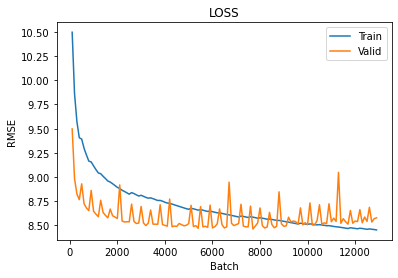

In [27]:
plt.plot(model[3], model[1])
plt.plot(model[3], model[2])

plt.title('LOSS')
plt.xlabel('Batch')
plt.ylabel('RMSE')
plt.legend(['Train', 'Valid'])
plt.show()

### Q5 Conclusion
可以發現在有Dropout的情況下，隨著Batch增加Train的RMSE會越來越低，蠻符合常理的，而Valid也是隨著Batch增加時在略略降低。另外，有Dropout的表現完全比沒有Dropout好，所以此資料集適合搭配Dropout的方法訓練。

## Q6 Explore Number of Hidden Units 
使用上題的模型，考慮H = 20, 180, 360。 討論H = 20, 45, 180, 360的Test RMSE。

H = 20

In [28]:
H = 20

model = MLP_dropout(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = torch.nn.MSELoss()

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader, 0)
# Test
test(model[0], device, testloader, loss_function)

Test Loss: 8.8414


8.84136374097605

H = 180

In [29]:
H = 180

model = MLP_dropout(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = torch.nn.MSELoss()

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader, 0)
# Test
test(model[0], device, testloader, loss_function)

Test Loss: 9.1532


9.153216062903729

H = 360

In [30]:
H = 360

model = MLP_dropout(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = torch.nn.MSELoss()

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader, 0)
# Test
test(model[0], device, testloader, loss_function)

Test Loss: 9.6403


9.64026041819402

### Q6 Conclusion
表現優劣排名為: 20 > 45 > 180 > 360。推測在有Dropout的情形下不宜太多hidden layer。

## Q7 L2 + L1 Loss 
我們前面的小題皆是使用SSE，也就是L2 Loss。一個改善模型訓練的方式是使用多種類似的Loss，以線性組合的方式建構Loss Function。請使用Q5中的MLP with Dropout模型 (H = 90)，並以L2 + L1 Loss訓練模型。這個Loss的定義如下:

$$
loss(\mathbf{y}, \hat{\mathbf{y}}) = z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i = 1}^n | y_i - \hat{y}_i |,
$$
其中z為實數且$0 <=z <= 1$。

使用z = 0.5。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.0, 0.1, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。

In [31]:
class q7loss(torch.nn.Module):
    def __init__(self, z):
        super().__init__()
        self.z = z
    def forward(self, x, y):
        return z * torch.mean(torch.pow((x-y),2) + (1-z) * torch.mean(torch.abs(x-y)))

In [32]:
H = 90
z = 0.5

model = MLP_dropout(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = q7loss(z)

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader)
# Test
test(model[0], device, testloader, loss_function)

Batch: 1000 Training Loss: 6.5543 Validation Loss: 6.2177
Current best validation RMSE: 6.2177 @ 1000
Batch: 2000 Training Loss: 6.4031 Validation Loss: 6.1712
Current best validation RMSE: 6.1712 @ 2000
Batch: 3000 Training Loss: 6.3473 Validation Loss: 6.2886
Current best validation RMSE: 6.1554 @ 2500
Batch: 4000 Training Loss: 6.2966 Validation Loss: 6.1582
Current best validation RMSE: 6.1293 @ 3700
Batch: 5000 Training Loss: 6.2458 Validation Loss: 6.1434
Current best validation RMSE: 6.1293 @ 3700
Batch: 6000 Training Loss: 6.2292 Validation Loss: 6.1508
Current best validation RMSE: 6.1293 @ 3700
Batch: 7000 Training Loss: 6.1941 Validation Loss: 6.1729
Current best validation RMSE: 6.1293 @ 3700
Batch: 8000 Training Loss: 6.1851 Validation Loss: 6.2534
Current best validation RMSE: 6.1293 @ 3700
==================== Training Finished ====================
Test Loss: 6.4496


6.449558311857376

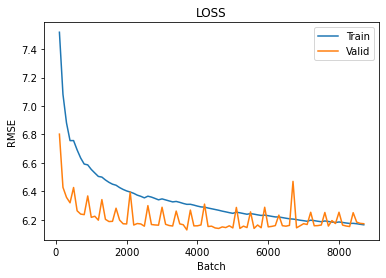

In [33]:
plt.plot(model[3], model[1])
plt.plot(model[3], model[2])

plt.title('LOSS')
plt.xlabel('Batch')
plt.ylabel('RMSE')
plt.legend(['Train', 'Valid'])
plt.show()

z = 0.0

In [34]:
z = 0.0

model = MLP_dropout(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = q7loss(z)

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader, 0)
# Test
test(model[0], device, testloader, loss_function)

Test Loss: 0.0000


0.0

z = 0.1

In [35]:
z = 0.1

model = MLP_dropout(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = q7loss(z)

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader, 0)
# Test
test(model[0], device, testloader, loss_function)

Test Loss: 2.9200


2.9200031415437055

z = 0.9

In [36]:
z = 0.9

model = MLP_dropout(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = q7loss(z)

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader, 0)
# Test
test(model[0], device, testloader, loss_function)

Test Loss: 8.6319


8.631857044047065

z = 1.0

In [37]:
z = 1.0

model = MLP_dropout(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = q7loss(z)

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader, 0)
# Test
test(model[0], device, testloader, loss_function)

Test Loss: 8.9296


8.929617883749891

### Q7 Conclusion
表現優劣分別為: 0.0 > 0.1 > 0.5 > 0.9 > 1。推測z越小越好。

## Q8 L2 + Customerized Loss 
考慮另一個比較特別的Loss Function

$$
qloss(\mathbf{y}, \hat{\mathbf{y}}) = \sum_{i=1}^n \{ q (y_i - \hat{y}_i)_+ + (1 - q) (\hat{y}_i - y_i)_+ \},
$$
其中q為參數且$0<=q<=1$，而$(y_i - \hat{y}_i)_+$是取正值的意思。也就是說如果$(y_i - \hat{y}_i) > 0$，則$(y_i - \hat{y}_i)_+ = y_i - \hat{y}_i$，否則$(y_i - \hat{y}_i)_+ = 0$。

令模型的Loss為$z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i=1}^n \{ 0.5 (y_i - \hat{y}_i)_+ + 0.5 (\hat{y}_i - y_i)_+ \} $。請使用Q5中的MLP with Dropout模型(H = 90)，令z = 0。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.1, 0.5, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。

In [38]:
class q8loss(torch.nn.Module):
    def __init__(self, z):
        super().__init__()
        self.z = z
    def forward(self, x, y):
        return z * torch.mean(torch.pow((x-y),2)) + (1-z) * torch.mean(torch.abs(0.5*(x-y)))

In [39]:
z = 0.0

model = MLP_dropout(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = q8loss(z)

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader)
# Test
test(model[0], device, testloader, loss_function)

Batch: 1000 Training Loss: 1.7617 Validation Loss: 1.6944
Current best validation RMSE: 1.6944 @ 1000
Batch: 2000 Training Loss: 1.7280 Validation Loss: 1.6807
Current best validation RMSE: 1.6807 @ 2000
Batch: 3000 Training Loss: 1.7157 Validation Loss: 1.7053
Current best validation RMSE: 1.6751 @ 2800
Batch: 4000 Training Loss: 1.7061 Validation Loss: 1.6719
Current best validation RMSE: 1.6719 @ 3600
Batch: 5000 Training Loss: 1.6968 Validation Loss: 1.6698
Current best validation RMSE: 1.6693 @ 4300
Batch: 6000 Training Loss: 1.6938 Validation Loss: 1.6693
Current best validation RMSE: 1.6684 @ 5400
Batch: 7000 Training Loss: 1.6880 Validation Loss: 1.6689
Current best validation RMSE: 1.6678 @ 6200
Batch: 8000 Training Loss: 1.6864 Validation Loss: 1.7014
Current best validation RMSE: 1.6675 @ 7300
Batch: 9000 Training Loss: 1.6824 Validation Loss: 1.6700
Current best validation RMSE: 1.6675 @ 7300
Batch: 10000 Training Loss: 1.6791 Validation Loss: 1.6701
Current best validation

1.7030496910421464

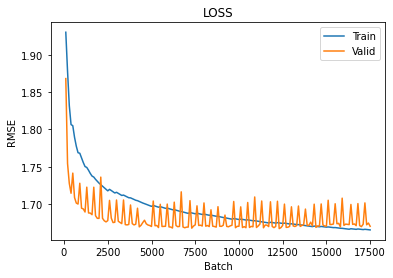

In [40]:
plt.plot(model[3], model[1])
plt.plot(model[3], model[2])

plt.title('LOSS')
plt.xlabel('Batch')
plt.ylabel('RMSE')
plt.legend(['Train', 'Valid'])
plt.show()

z = 0.1

In [41]:
z = 0.1

model = MLP_dropout(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = q7loss(z)

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader, 0)
# Test
test(model[0], device, testloader, loss_function)

Test Loss: 2.9246


2.9245509671378165

z = 0.5

In [42]:
z = 0.5

model = MLP_dropout(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = q7loss(z)

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader, 0)
# Test
test(model[0], device, testloader, loss_function)

Test Loss: 6.4382


6.438191138182021

z = 0.9

In [43]:
z = 0.9

model = MLP_dropout(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = q7loss(z)

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader, 0)
# Test
test(model[0], device, testloader, loss_function)

Test Loss: 8.5347


8.534735918967545

z = 1.0

In [44]:
z = 1.0

model = MLP_dropout(D_in, D_out, H).to(device)
model = model.float()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = q7loss(z)

# Train
model = train(model, device, epochs, optimizer, loss_function, subtrainloader, validloader, 0)
# Test
test(model[0], device, testloader, loss_function)

Test Loss: 8.9423


8.942301773056709

### Q8 Conclusion
表現優劣分別為: 0.0 > 0.1 > 0.5 > 0.9 > 1。推測z越小越好。